In [1]:
import argparse
import torch
from torch_geometric.data import DataLoader
#import models_ggnn_oldpipe as models
import models_fastsim as models
import utils
import matplotlib
from copy import deepcopy
import os
import copy
import uproot
import awkward as ak
import xgboost as xgb

#matplotlib.use("pdf")
import numpy as np
import random
import pickle
import joblib
from timeit import default_timer as timer
from tqdm import tqdm

import matplotlib as mpl
import imageio

from scipy import integrate as integrate
#mpl.use("pdf")
import matplotlib.pyplot as plt
import mplhep as hep

hep.set_style(hep.style.CMS)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

from pyjet import cluster, DTYPE_PTEPM
from collections import OrderedDict
import scipy.stats
from scipy.stats import norm
from scipy.stats import rv_histogram
from scipy import stats

True


/depot/cms/private/users/gpaspala/miniconda3/envs/DeepPuppi/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/tmp/ipykernel_3534780/3555834389.py:31: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


In [2]:
def deltaPhiNew(dphis):
    dphis = np.where(dphis > np.pi, dphis - 2*np.pi, dphis)
    dphis = np.where(dphis <-np.pi, dphis + 2*np.pi, dphis)
    return dphis

def deltaRNew(detas, dphis):
    """
    calculate the deltaR based on the input deta and phi
    """
    dphis = deltaPhiNew(dphis)
    dR = np.sqrt(detas**2 + dphis**2)
    return dR

In [3]:
class Args(object):
    def __init__(self, model_type = 'Gated', do_boost=False, extralayers=False):
        self.model_type = model_type
        self.num_layers = 2
        self.batch_size = 1
        self.hidden_dim = 20
        self.dropout = 0
        self.opt = 'adam'
        self.weight_decay = 0
        self.lr = 0.01
        self.do_boost = do_boost
        self.extralayers = extralayers

In [4]:
args = Args()

In [5]:
class PerformanceMetrics(object):
    def __init__(self):
        pt = 0.
        pt_diff = 0.
        mass_diff = 0.
        dR_diff = 0.
        mass_reco =0.
        mass_gen =0.
        pt_reco =0.
        pt_gen =0.
        eta_reco = 0.
        phi_reco = 0.

In [6]:
def generate_mask(dataset):
    # how many LV and PU to sample
    # dataset = deepcopy(dataset_org)
    for graph in dataset:
        LV_index = graph.LV_index
        PU_index = graph.PU_index
        original_feature = graph.x[:, 0:graph.num_feature_actual]

        num_select_LV = 10
        num_select_PU = 160

        if LV_index.shape[0] < num_select_LV or PU_index.shape[0] < num_select_PU:
            num_select_LV = min(LV_index.shape[0], num_select_LV)
            num_select_PU = min(PU_index.shape[0], num_select_PU)

        # generate the index for LV and PU samples for training mask
        gen_index_LV = random.sample(range(LV_index.shape[0]), num_select_LV)
        selected_LV_train = LV_index[gen_index_LV]

        gen_index_PU = random.sample(range(PU_index.shape[0]), num_select_PU)
        selected_PU_train = PU_index[gen_index_PU]

        training_mask = np.concatenate((selected_LV_train, selected_PU_train), axis=None)
        #print(training_mask)

        # construct mask vector for training and testing
        mask_training = torch.zeros(graph.num_nodes, 1)
        mask_training[[training_mask.tolist()]] = 1

        x_concat = torch.cat((original_feature, mask_training), 1)
        graph.x = x_concat

        
        # mask the puppiWeight as default Neutral(here puppiweight is actually fromLV in ggnn dataset)
        puppiWeight_default_one_hot_training = torch.cat((torch.zeros(graph.num_nodes, 1),
                                                          torch.zeros(graph.num_nodes, 1),
                                                          torch.ones(graph.num_nodes, 1)), 1)
        puppiWeight_default_one_hot_training = puppiWeight_default_one_hot_training.type(torch.float32)
        
        #mask the pdgID for charge particles
        pdgId_one_hot_training = torch.cat((torch.zeros(graph.num_nodes, 1),
                                                          torch.zeros(graph.num_nodes, 1),
                                                          torch.ones(graph.num_nodes, 1)), 1)       
        pdgId_one_hot_training = pdgId_one_hot_training.type(torch.float32)

        pf_dz_training_test=torch.clone(original_feature[:,6:7])
        pf_dz_training_test = torch.zeros(graph.num_nodes, 1)    
        

        # -4 is for one hot encoding of fromLV and one mask; -1 is for final puppiweight
        #default_data_training = torch.cat(
         #   (original_feature[:, 0:(graph.num_features - 4 - 1)], puppiWeight_default_one_hot_training,
         #    original_feature[:, -1].view(-1, 1)), 1)
        default_data_training = torch.cat(
             (original_feature[:, 0:(graph.num_feature_actual - 7)],pdgId_one_hot_training, pf_dz_training_test ,puppiWeight_default_one_hot_training), 1)
        

        concat_default = torch.cat((graph.x, default_data_training), 1)
        graph.x = concat_default

In [7]:
def test(filelists, models={}):
    
    for model in models.values():
        model.to('cuda:0')
        model.eval()
    
    performances_jet_puppi = []
    performances_jet_puppi_wcut = []
    performances_jet_pf = []
    
    mets_truth = []
    mets_puppi = []
    mets_puppi_wcut = []
      
    
    performances_jet_pred = OrderedDict()
    mets_pred = OrderedDict()
    
    for modelname in models.keys():
        performances_jet_pred[modelname] = []
        mets_pred[modelname] = []
       
    
    ievt = 0
    for ifile in filelists:
        print("ifile: ", ifile)
        fp = open(ifile, "rb")
        dataset = joblib.load(fp)
        generate_neu_mask(dataset)
        generate_mask(dataset)
        data = DataLoader(dataset, batch_size=1)
        loader = data
        
        for data in loader:
            ievt += 1
            #if ievt > 10:
            #    break
            
            if ievt%10 == 0:
                print("processed {} events".format(ievt))
            with torch.no_grad():
                data = data.to(device)
                # max(dim=1) returns values, indices tuple; only need indices
                
                # loop over model in models and run the inference
                preds = []

                for model in models.values():
                    model.to('cuda:0')
                    model.eval()
                    
                    pred = model.forward(data)
                    #print("pred here: ", pred)
                    preds.append(pred)
            
                #met_truth, perfs_jet_puppi, met_puppi, perfs_jet_puppi_wcut, met_puppi_wcut, perfs_jet_pred, mets_fromF_pred = postProcessing(data, preds)
                #met_truth,perfs_jet_puppi,perfs_jet_pf,perfs_jet_puppi_wcut,perfs_jet_pred, mets_fromF_pred, perfs_jet_gen = postProcessing(data, preds)
                met_truth, perfs_jet_puppi, met_puppi, perfs_jet_puppi_wcut, met_puppi_wcut, perfs_jet_pred, mets_fromF_pred,  perfs_jet_gen, met_pf = postProcessing(data, preds)
                
                
                
                
                imodel = 0
                for modelname in models.keys():
                    #print("modelname ", perfs_jet_pred[imodel])
                    #print("performances_jet_pred modelname", performances_jet_pred[modelname] )
                    performances_jet_pred[modelname] += perfs_jet_pred[imodel]
                    mets_pred[modelname].append(mets_fromF_pred[imodel])
                    imodel += 1
                
        fp.close()


    #return mets_truth,performances_jet_puppi,performances_jet_pf,perfs_jet_puppi_wcut ,performances_jet_pred, mets_pred, performances_jet_gen
    return mets_truth, performances_jet_puppi, mets_puppi, performances_jet_puppi_wcut, mets_puppi_wcut, performances_jet_pred, mets_pred,performances_jet_gen, mets_pf

In [8]:
def generate_neu_mask(dataset):
    # all neutrals with pt cuts are masked for evaluation
    for graph in dataset:
        nparticles = graph.num_nodes
        graph.num_feature_actual = graph.num_features
        Neutral_index = graph.Neutral_index
        Neutral_feature = graph.x[Neutral_index]
        Neutral_index = Neutral_index[torch.where(Neutral_feature[:, 2] > 0.5)[0]]
        
        

        mask_neu = torch.zeros(nparticles, 1)
        mask_neu[Neutral_index, 0] = 1
        graph.mask_neu = mask_neu

    return dataset

In [9]:
def clusterJets(pt, eta, phi, ptcut=0., deltaR=0.4):
    """
    cluster the jets based on the array of pt, eta, phi,
    of all particles (masses are assumed to be zero),
    with pyjet clustering algo
    """
    # cleaning zero pt-ed objects
    pt_wptcut   = pt[pt > ptcut]
    eta_wptcut  = eta[pt > ptcut]
    phi_wptcut  = phi[pt > ptcut]
    mass_wptcut = np.zeros(pt_wptcut.shape[0])
    
    event = np.column_stack((pt_wptcut, eta_wptcut, phi_wptcut, mass_wptcut))
    event.dtype = DTYPE_PTEPM
    sequence = cluster(event, R=deltaR, p=-1)
    jets = sequence.inclusive_jets(ptmin=30)
    
    #print ("done")
    
    return jets

def deltaPhi(phi1, phi2):
    dphi = phi1 - phi2
    while dphi > np.pi:
        dphi -= 2 * np.pi
    while dphi < -np.pi:
        dphi += 2 * np.pi
    return dphi

def deltaR(eta1, phi1, eta2, phi2):
    """
    calculate the deltaR between two jets/particles
    """
    deta = eta1 - eta2
    dphi = phi1 - phi2
    while dphi > np.pi:
        dphi -= 2 * np.pi
    while dphi < -np.pi:
        dphi += 2 * np.pi
    return np.hypot(deta, dphi)

def deltaRJet(jet1, jet2):
    """
    calculate the deltaR of the two PseudoJet
    """
    return deltaR(jet1.eta, jet1.phi, jet2.eta, jet2.phi)

def matchJets(jets_truth, jets_reco, dRcut=0.1):
    """
    match the jets in jets_reco to jets_truth,
    based on the deltaR
    """
    matched_indices = []
    
    jets_truth_indices = list(range(len(jets_truth)))
    jets_reco_indices  = list(range(len(jets_reco)))
    
    for ijet_reco in jets_reco_indices:
        for ijet_truth in jets_truth_indices:
            #print("deltR between {} and {} is {}".format(ijet_truth, ijet_reco, deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco])))
            if deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco]) < dRcut:
                matched_indices.append((ijet_truth, ijet_reco))
                jets_truth_indices.remove(ijet_truth)
                break
    
    return matched_indices

def compareJets(jets_truth, jets_reco, dRcut=0.1):
    """
    match jets between truth and reco using matchJets,
    and then compared the matched deltaR, pt, and mass
    """
    performances = []
    
    matched_indices = matchJets(jets_truth, jets_reco, dRcut=dRcut)
    #print ("matched_indices:", matched_indices)
    for ijet_truth, ijet_reco in matched_indices:
        perf = PerformanceMetrics()
        perf.pt_truth = jets_truth[ijet_truth].pt
        perf.mass_diff =  (jets_reco[ijet_reco].mass - jets_truth[ijet_truth].mass)/(jets_truth[ijet_truth].mass+1e-6)
        perf.pt_diff   =  (jets_reco[ijet_reco].pt   - jets_truth[ijet_truth].pt)/(jets_truth[ijet_truth].pt+1e-6)
        perf.dR_diff   =  deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco])
        perf.mass_reco =  jets_reco[ijet_reco].mass
        perf.mass_gen  =  jets_truth[ijet_truth].mass
        perf.pt_reco   =  jets_reco[ijet_reco].pt
        perf.pt_gen    =  jets_truth[ijet_truth].pt
        perf.eta_reco  =  jets_reco[ijet_reco].eta
        perf.phi_reco  =  jets_reco[ijet_reco].phi
        performances.append(perf)
    return performances

def calculateMET(pt, phi):
    """
    calculate the MET based on all particles pt and phi
    """
    met_x = np.sum(pt * np.cos(phi), axis=0)
    met_y = np.sum(pt * np.sin(phi), axis=0)
    return np.hypot(met_x, met_y)


In [10]:
def postProcessing(data, preds):
    pt_gen = np.array(data.GenPart_nump[ :,2].cpu().detach())
    eta_gen = np.array(data.GenPart_nump[ :,0].cpu().detach())
    phi_gen = np.array(data.GenPart_nump[ :,1].cpu().detach())
    mass_gen =  np.zeros(pt_gen.shape[0])
    
    pt_gen[pt_gen<0.5]=0
    jets_gen = clusterJets(pt_gen,eta_gen,phi_gen, mass_gen)
    
    ##pf from graph
    pt      = np.array(data.x[:,2].cpu().detach())
    eta     = np.array(data.x[:,0].cpu().detach())
    phi     = np.array(data.x[:,1].cpu().detach())
    puppi = np.array(data.x[:,data.num_feature_actual[0].item()-1].cpu().detach())
    truth = np.array(data.y.cpu().detach())
    mass  = np.zeros(pt.shape[0])
    
    #puppi_raw = np.array(data.PFPartraw_nump[ :,5].cpu().detach())
    puppi_raw = np.array(data.PFPartraw_nump[ :,6].cpu().detach()) ##PuppiPF_Chg
    
    pt[pt<0.5]=0
    
    jets_pf =clusterJets(pt, eta, phi)
    
     # apply CHS to puppi weights
    charge_index = data.Charge_index[0]
    puppi[charge_index] = truth[charge_index]
    
    pt_truth = pt * truth
    #print (pt_truth)
    # puppi information
    #print (puppi)
    pt_puppi = pt * puppi_raw
    
    
    # cluster jets with truth particles
    jets_truth = clusterJets(pt_truth, eta, phi)
    # apply some weight cuts on puppi
    #cut = 0.41 #GeV
    #wcut = 0.17 #used
    #cut = 0.99 #GeV #used
    cut = 0.99 #GeV
    wcut = 0.15
    #cut = 1.242 #GeV
    #wcut = 0.115
    pt_puppi_wcut = np.array(pt_puppi, copy=True)
    pt_puppi_wcut[(puppi<wcut) | (pt_puppi<cut)] = 0.
    
    jets_puppi = clusterJets(pt_puppi, eta, phi)
    performances_jet_puppi = compareJets(jets_gen, jets_puppi)
    #performances_jet_puppi = compareJets(jets_truth, jets_puppi)
    
    jets_puppi_wcut = clusterJets(pt_puppi_wcut, eta, phi)
    #performances_jet_puppi_wcut = compareJets(jets_truth, jets_puppi_wcut)
    performances_jet_puppi_wcut = compareJets(jets_gen, jets_puppi_wcut)
    
    performances_jet_gen = compareJets(jets_gen, jets_pf)
    
     # calculate MET and compare
    met_truth = calculateMET(pt_gen, phi_gen)
    met_puppi = calculateMET(pt_puppi, phi)
    met_puppi_wcut = calculateMET(pt_puppi_wcut, phi)
    met_pf = calculateMET(pt,phi)
    #met_pred  = calculateMET(pt_pred,  phi)
    #met_pred2 = calculateMET(pt_pred2, phi)
    #print("***** one event ********")
    #print("met truth", met_truth)
    #print("met puppi", met_puppi)
    #print("met puppi wcut", met_puppi_wcut)
    #print("met pred", met_pred)
   
    
    # evaluate the performances for the predictions
    performances_jet_pred = []
    mets_pred = []
    gnn_pred =[]
    puppi_wgt=[]
    puppi_wgt.append(puppi_raw)
    
    
    for pred in preds:
        #print("preds: ", pred)
        pred = np.array(pred[0][:,0].cpu().detach())
        
        #print("prediction: ", pred)
        
        # apply CHS to predictions
        charge_index = data.Charge_index[0]
        pred[charge_index] = truth[charge_index]
        gnn_pred.append(pred)
        pt_pred = pt * pred
        #pt_pred = pt * pred * (puppi_raw/pred)
        #print("corrected Pt: ", pt_pred)
        jets_pred  = clusterJets(pt_pred,  eta, phi)
        performance_jet_pred = compareJets(jets_gen, jets_pred)
        
        # MET
        met_pred  = calculateMET(pt_pred,  phi)
        
        performances_jet_pred.append( performance_jet_pred )
        mets_pred.append( met_pred )

    return met_truth, performances_jet_puppi, met_puppi, performances_jet_puppi_wcut, met_puppi_wcut, performances_jet_pred, mets_pred,performances_jet_gen,met_pf,gnn_pred,puppi_wgt  
    #return met_truth, perfs_jet_puppi, met_puppi, perfs_jet_puppi_wcut, met_puppi_wcut, perfs_jet_pred, mets_fromF_pred,  perfs_jet_gen
    
    
  

In [11]:
def test(filelists, models={}):
    
    for model in models.values():
        model.to('cuda:0')
        model.eval()
    
    performances_jet_puppi = []
    performances_jet_puppi_wcut = []
    performances_jet_gen = []
    
    mets_truth = []
    mets_puppi = []
    mets_puppi_wcut = []
    mets_pf = []
    gnn_preds =[]
    puppi_wgts = []
    
    
    performances_jet_pred = OrderedDict()
    mets_pred = OrderedDict()
    for modelname in models.keys():
        performances_jet_pred[modelname] = []
        mets_pred[modelname] = []
    
    ievt = 0
    for ifile in filelists:
        print("ifile: ", ifile)
        fp = open(ifile, "rb")
        dataset = joblib.load(fp)
        generate_neu_mask(dataset)
        generate_mask(dataset)
        data = DataLoader(dataset, batch_size=1)
        loader = data
        
        for data in loader:
            ievt += 1
            #if ievt > 10:
            #    break
            
            if ievt%10 == 0:
                print("processed {} events".format(ievt))
            with torch.no_grad():
                data = data.to(device)
                # max(dim=1) returns values, indices tuple; only need indices
                
                # loop over model in models and run the inference
                preds = []

                for model in models.values():
                    model.to('cuda:0')
                    model.eval()
                    
                    pred = model.forward(data)
                    #print("pred here: ", pred)
                    preds.append(pred)
            
                met_truth, perfs_jet_puppi, met_puppi, perfs_jet_puppi_wcut, met_puppi_wcut, perfs_jet_pred, mets_fromF_pred, perfs_jet_gen, met_pf, gnn_pred,puppi_wgt = postProcessing(data, preds)
               
                #return met_truth, performances_jet_puppi, met_puppi, performances_jet_puppi_wcut, met_puppi_wcut, performances_jet_pred, mets_pred,performances_jet_gen 
                
            
                performances_jet_puppi += perfs_jet_puppi
                performances_jet_puppi_wcut += perfs_jet_puppi_wcut
                performances_jet_gen += perfs_jet_gen
                #performances_jet_pred += perfs_jet_pred
                #performances_jet_pred2 += perfs_jet_pred2
                
                mets_truth.append(met_truth)
                mets_puppi.append(met_puppi)
                mets_puppi_wcut.append(met_puppi_wcut)
                mets_pf.append(met_pf)
                gnn_preds.append(gnn_pred)
                puppi_wgts.append(puppi_wgt)
                
                imodel = 0
                for modelname in models.keys():
                    #print("modelname ", perfs_jet_pred[imodel])
                    #print("performances_jet_pred modelname", performances_jet_pred[modelname] )
                    performances_jet_pred[modelname] += perfs_jet_pred[imodel]
                    mets_pred[modelname].append(mets_fromF_pred[imodel])
                    imodel += 1
                
        fp.close()


    return mets_truth, performances_jet_puppi, mets_puppi, performances_jet_puppi_wcut, mets_puppi_wcut, performances_jet_pred, mets_pred, performances_jet_gen, mets_pf, gnn_preds, puppi_wgts
    


In [12]:
filelists = ["/home/gpaspala/new_Pileup_GNN/Pileup_GNN/datasets/dataset_graph_puppi_PF_puppiWeightChg_1500"]#,
             #"/home/gpaspala/new_Pileup_GNN/Pileup_GNN/datasets/dataset_graph_puppi_2000"]

In [13]:
ifile = "/home/gpaspala/new_Pileup_GNN/Pileup_GNN/datasets/dataset_graph_puppi_1500"
fp = open(ifile, "rb")
dataset = joblib.load(fp)
generate_neu_mask(dataset)
generate_mask(dataset)

In [14]:
model_gated_boost = models.GNNStack(10, args.hidden_dim, 1, args)
#model_load.load_state_dict(torch.load('best_valid_model_semi.pt'))
#model_gated_boost.load_state_dict(torch.load('/home/gpaspala/new_Pileup_GNN/Pileup_GNN/fast_simulation/test/best_valid_model.pt'))
model_gated_boost.load_state_dict(torch.load('/home/gpaspala/new_Pileup_GNN/Pileup_GNN/fast_simulation/test/best_valid_model_ZJ.pt'))


<All keys matched successfully>

In [15]:
modelcolls = OrderedDict()
modelcolls['gated_boost'] = model_gated_boost

In [16]:
mets_truth, performances_jet_puppi, mets_puppi, performances_jet_puppi_wcut, mets_puppi_wcut, performances_jet_pred, mets_pred,performances_jet_gen,mets_pf, gnn_preds, puppi_wgts = test(filelists, modelcolls)

ifile:  /home/gpaspala/new_Pileup_GNN/Pileup_GNN/datasets/dataset_graph_puppi_PF_puppiWeightChg_1500


/depot/cms/private/users/gpaspala/miniconda3/envs/DeepPuppi/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


processed 10 events
processed 20 events
processed 30 events
processed 40 events
processed 50 events
processed 60 events
processed 70 events
processed 80 events
processed 90 events
processed 100 events
processed 110 events
processed 120 events
processed 130 events
processed 140 events
processed 150 events
processed 160 events
processed 170 events
processed 180 events
processed 190 events
processed 200 events
processed 210 events
processed 220 events
processed 230 events
processed 240 events
processed 250 events
processed 260 events
processed 270 events
processed 280 events
processed 290 events
processed 300 events
processed 310 events
processed 320 events
processed 330 events
processed 340 events
processed 350 events
processed 360 events
processed 370 events
processed 380 events
processed 390 events
processed 400 events
processed 410 events
processed 420 events
processed 430 events
processed 440 events
processed 450 events
processed 460 events
processed 470 events
processed 480 events
p

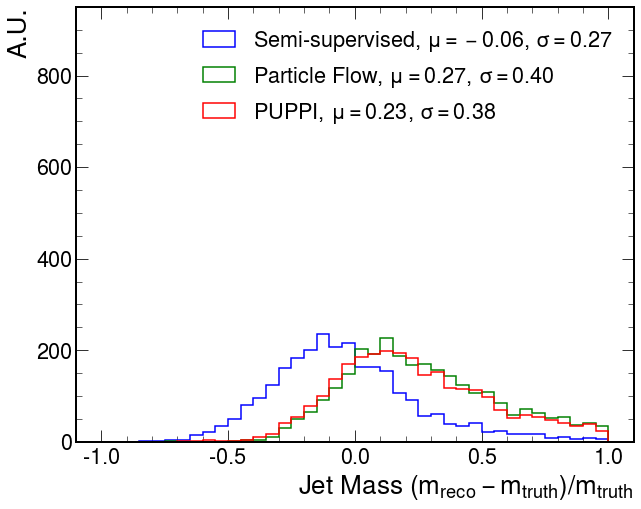

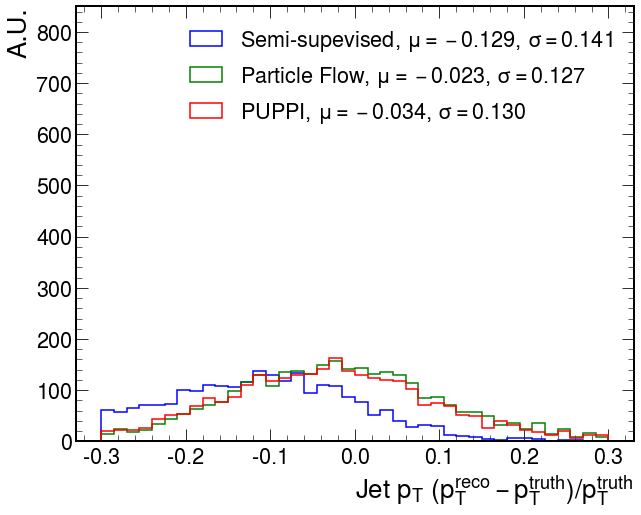

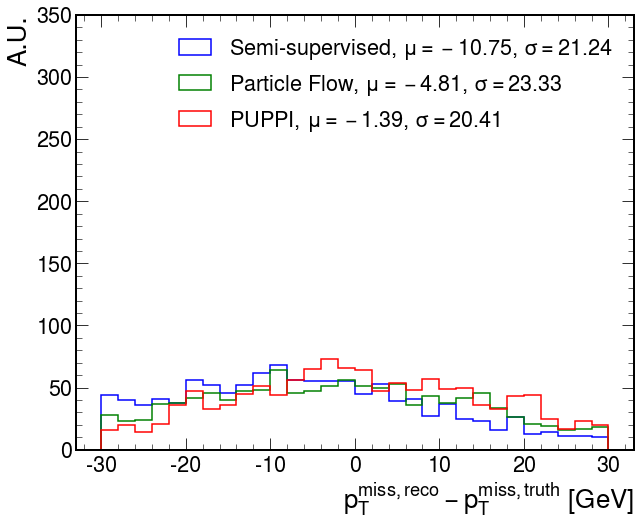

In [17]:
def getResol(input):
    return (np.quantile(input, 0.84) - np.quantile(input, 0.16))/2

def getStat(input):
    return float(np.median(input)), float(getResol(input))

performances_jet_pred0 = performances_jet_pred['gated_boost']
#performances_jet_pred1 = performances_jet_pred['gated_noboost']
#performances_jet_pred2 = performances_jet_pred['graphsage_boost']
#performances_jet_pred3 = performances_jet_pred['graphsage_noboost']
#performances_jet_pred4 = performances_jet_pred['gated_boost_sp']


mets_pred0 = mets_pred['gated_boost']

linewidth=1.5


%matplotlib inline
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,8))
mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_pred0])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supervised, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))
mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_gen])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='green', linewidth=linewidth, density=False, label=r'Particle Flow, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))

mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_puppi])
#mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_puppi])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))
#plt.xlim(-1.0,1.3)
plt.xlabel(r"Jet Mass $(m_{reco} - m_{truth})/m_{truth}$")
plt.ylabel('A.U.')
plt.ylim(0, 950)
plt.legend()
plt.savefig("Jet_mass_diff.pdf")
plt.savefig("Jet_mass_diff.png")
plt.show()


#%matplotlib inline
fig = plt.figure(figsize=(10,8))

pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_pred0])
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supevised, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_gen])
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='green', linewidth=linewidth, density=False, label=r'Particle Flow, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
#plt.xlim(0,40)
pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_puppi])
#plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PUPPI')
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
#plt.xlim(0,40)
plt.ylim(0, 850)
plt.xlabel(r"Jet $p_{T}$ $(p^{reco}_{T} - p^{truth}_{T})/p^{truth}_{T}$")
plt.ylabel('A.U.')
plt.legend()
plt.savefig("Jet_pT_diff.pdf")
plt.savefig("Jet_pT_diff.png")
plt.show()


# MET resolution
#%matplotlib inline

fig = plt.figure(figsize=(10,8))
mets_diff = (np.array(mets_pred0) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supervised, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))
#mets_diff = (np.array(mets_pred4) - np.array(mets_truth))
#plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='green', linewidth=linewidth, density=False, label=r'Fully-supervised, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))

mets_diff = (np.array(mets_pf) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='green', linewidth=linewidth, density=False, label=r'Particle Flow, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))


mets_diff = (np.array(mets_puppi) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))

plt.xlabel(r"$p^{miss, reco}_{T} - p^{miss, truth}_{T}$ [GeV]")
plt.ylabel('A.U.')
plt.ylim(0,350)
plt.legend()
plt.savefig("MET_diff.pdf")
plt.savefig("MET_diff.png")
plt.show()


/tmp/ipykernel_3534780/2774062642.py:23: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 100)


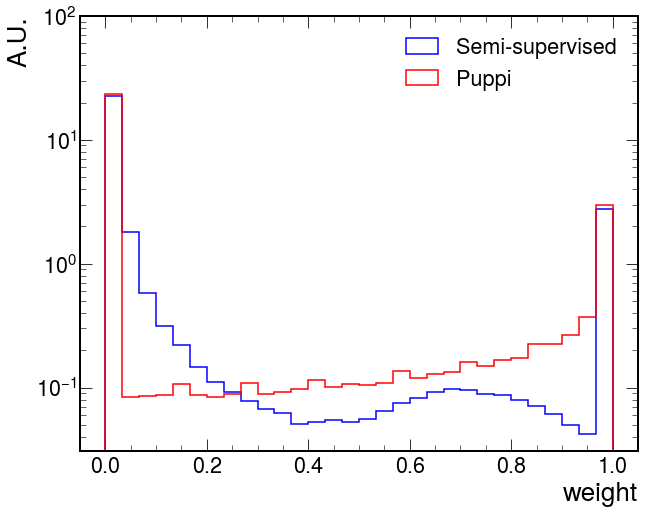

In [18]:
fig = plt.figure(figsize=(10,8))
#gnn = np.array(gnn_preds)

#gnn = ak.to_numpy(ak.flatten(gnn_preds[4]))
#gnn = np.vstack(gnn_preds)
#gnn=np.stack(gnn_preds)
gnn=ak.Array(gnn_preds)
gnn= ak.flatten(gnn[:,0,:])

puppi=ak.Array(puppi_wgts)
puppi= ak.flatten(puppi[:,0,:])


#print ("pred:" , gnn[:,0,:])
plt.hist(gnn, bins=30, range=(0,1), histtype='step', color='blue', linewidth=linewidth, density=True, label=r'Semi-supervised')

plt.hist(puppi, bins=30, range=(0,1), histtype='step', color='red', linewidth=linewidth, density=True, label=r'Puppi')


plt.xlabel("weight")
plt.yscale("log")
plt.ylabel('A.U.')
plt.ylim(0, 100)
plt.legend()
plt.savefig("GNN_Puppi_weights.png")

plt.show()

norm: <scipy.stats._continuous_distns.norm_gen object at 0x2ba7a8a45c40>
rv: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'a', 'args', 'b', 'cdf', 'dist', 'entropy', 'expect', 'interval', 'isf', 'kwds', 'logcdf', 'logpdf', 'logpmf', 'logsf', 'mean', 'median', 'moment', 'pdf', 'pmf', 'ppf', 'random_state', 'rvs', 'sf', 'stats', 'std', 'support', 'var']
pdf_gnn [0.39894228 0.39894228 0.39894228 ... 0.39842511 0.39881097 0.39867384]


/tmp/ipykernel_3534780/939395631.py:16: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 100)


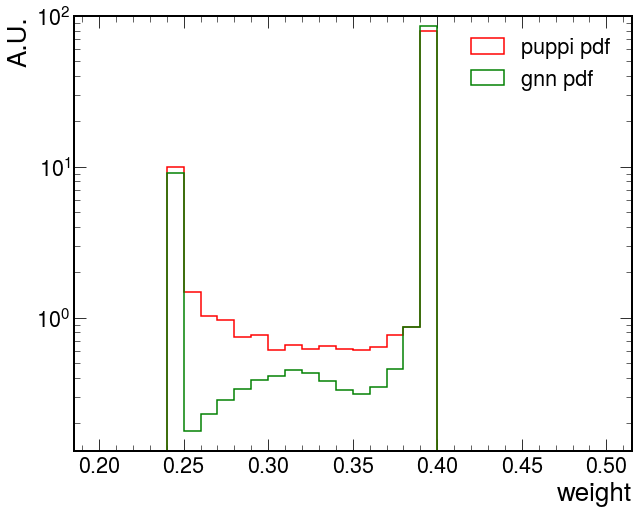

In [19]:
fig = plt.figure(figsize=(10,8))
pdf_puppi = norm.pdf(puppi)
pdf_gnn = norm.pdf(gnn)
rv = norm()
print("norm:" , norm)
dir(rv)
print("rv:" , dir(rv))
print("pdf_gnn" , pdf_gnn)

plt.hist(pdf_puppi, bins=30, range=(0.2,0.5), histtype='step', color='red', linewidth=linewidth, density=True, label=r'puppi pdf')
plt.hist(pdf_gnn, bins=30, range=(0.2,0.5), histtype='step', color='green', linewidth=linewidth, density=True, label=r'gnn pdf')

plt.xlabel("weight")
plt.yscale("log")
plt.ylabel('A.U.')
plt.ylim(0, 100)
plt.legend()
plt.savefig("GNN_Puppi_pdf.png")
#plt.savefig("GNN_Puppi_weights.png")

plt.show()

In [31]:
#for i in range(0,len(pdf_puppi)): 
    #print(array[i]) 
    #print("pdf_puppi" , pdf_puppi[i])
pdf_gnn.sort()
print("pdf_gnn" , pdf_gnn)
pdf_puppi.sort()

print("pdf_puppi" , pdf_puppi)

pdf_gnn [0.24197072 0.24197072 0.24197072 ... 0.39894228 0.39894228 0.39894228]
pdf_puppi [0.24197072 0.24197072 0.24197072 ... 0.39894228 0.39894228 0.39894228]


norm: <scipy.stats._continuous_distns.norm_gen object at 0x2ba7a8a45c40>
rv: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'a', 'args', 'b', 'cdf', 'dist', 'entropy', 'expect', 'interval', 'isf', 'kwds', 'logcdf', 'logpdf', 'logpmf', 'logsf', 'mean', 'median', 'moment', 'pdf', 'pmf', 'ppf', 'random_state', 'rvs', 'sf', 'stats', 'std', 'support', 'var']


/tmp/ipykernel_3534780/3953079394.py:15: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 100)


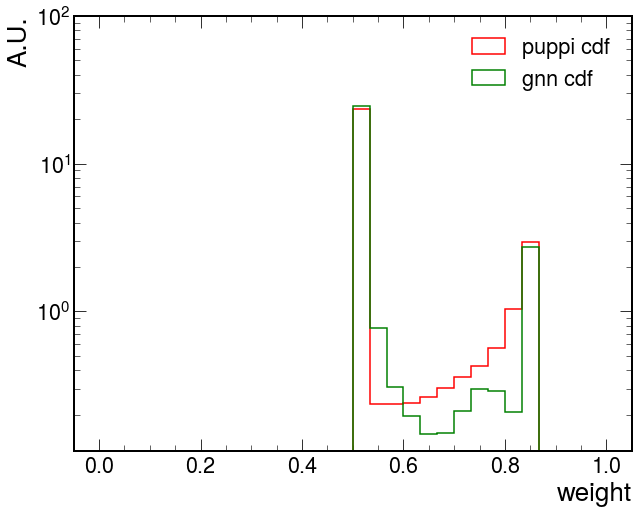

In [21]:
fig = plt.figure(figsize=(10,8))
cdf_puppi = norm.cdf(puppi)
cdf_gnn = norm.cdf(gnn)
rv = norm()
print("norm:" , norm)
dir(rv)
print("rv:" , dir(rv))

plt.hist(cdf_puppi, bins=30, range=(0,1), histtype='step', color='red', linewidth=linewidth, density=True, label=r'puppi cdf')
plt.hist(cdf_gnn, bins=30, range=(0,1), histtype='step', color='green', linewidth=linewidth, density=True, label=r'gnn cdf')

plt.xlabel("weight")
plt.yscale("log")
plt.ylabel('A.U.')
plt.ylim(0, 100)
plt.legend()
plt.savefig("GNN_Puppi_cdf.png")

plt.show()

S_PDF_puppi [2.41970725e-01 4.83941449e-01 7.25912174e-01 ... 4.25147095e+05
 4.25147494e+05 4.25147893e+05]
S_PDF_gnn [2.41970725e-01 4.83941449e-01 7.25912174e-01 ... 4.32753336e+05
 4.32753735e+05 4.32754134e+05]


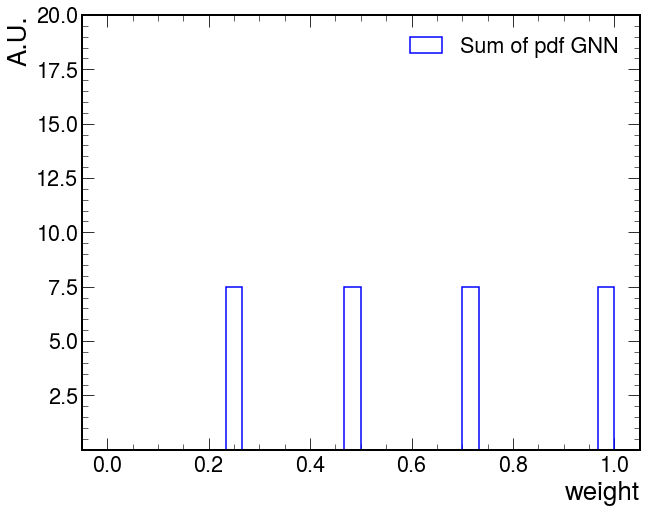

In [27]:
fig = plt.figure(figsize=(10,8))
S_PDF_puppi=np.cumsum(pdf_puppi,axis=0)
S_PDF_gnn=np.cumsum(pdf_gnn,axis=0)


#for i in range(0,len(S_PDF_puppi)): 
    #print("S_PDF_puppi" , S_PDF_puppi[i])

print ("S_PDF_puppi",S_PDF_puppi)
print ("S_PDF_gnn",S_PDF_gnn)
#plt.hist(S_PDF_puppi, bins=30, range=(0,1), histtype='step', color='red', linewidth=linewidth, density=True, label=r'Sum of pdf Puppi')
plt.hist(S_PDF_gnn, bins=30, range=(0,1), histtype='step', color='blue', linewidth=linewidth, density=True, label=r'Sum of pdf GNN')

plt.xlabel("weight")
#plt.yscale("log")
plt.ylabel('A.U.')
plt.ylim(0.001, 20)
plt.legend()
#plt.savefig("GNN_Puppi_cdf.png")

plt.show()
        


In [28]:
fig = plt.figure(figsize=(10,8))
sum_PDF_puppi=np.sum(pdf_puppi)
print (sum_PDF_puppi)




425147.8931306876


<Figure size 720x576 with 0 Axes>

(array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 7.5, 0. , 0. , 0. , 0. , 0. ,
        0. , 7.5, 0. , 0. , 0. , 0. , 0. , 0. , 7.5, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 7.5]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 [<matplotlib.patches.Polygon at 0x2ba7d0132460>])

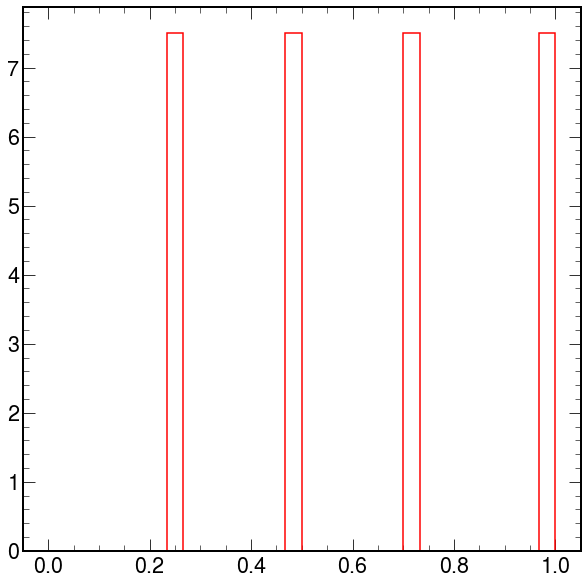

In [29]:
plt.hist(S_PDF_puppi, bins=30, range=(0,1), histtype='step', color='red', linewidth=linewidth, density=True, label=r'Sum of pdf Puppi')

In [30]:
a=[1,2,4]
cumsum =np.cumsum(a)
print(cumsum)
print(norm.cdf(a))
print(norm.pdf(a))


[1 3 7]
[0.84134475 0.97724987 0.99996833]
[2.41970725e-01 5.39909665e-02 1.33830226e-04]
